In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import missingno as msno
import pickle

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [3]:
from keras.optimizers import SGD, Adam, RMSprop, Adamax
from keras.models import Model
from keras import Input
from keras.layers import Dense, Dropout
from keras.metrics import AUC, Precision, Recall, TruePositives, FalsePositives
from keras.models import load_model

Using TensorFlow backend.


In [66]:
# import Dataset
Concat_final= pd.read_csv("PATH\\FMP_preprocessed_Short_inclTR.csv",";")

In [67]:
Concat_final = Concat_final.dropna()
Concat_final.dropna(inplace=True)
Concat_final= Concat_final.set_index("Unnamed: 0")


In [68]:
Concat_final["True_Return"].quantile(q=0.99)
Concat_final["True_Return"].quantile(q=0.01)

-0.9519311928399999

In [69]:
# Outliers?
Concat_final["True_Return"][Concat_final["True_Return"]<-1]=-1
# more than 10 times return in 3 years?
Concat_final=Concat_final[Concat_final["True_Return"]<Concat_final["True_Return"].quantile(q=0.99)]
Concat_final=Concat_final[Concat_final["True_Return"]>Concat_final["True_Return"].quantile(q=0.01)]
Concat_final=Concat_final[Concat_final["index"]>2000]

C:\Users\Vincent\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
Concat_final["neg_class"]= Concat_final["True_Return"]<-0

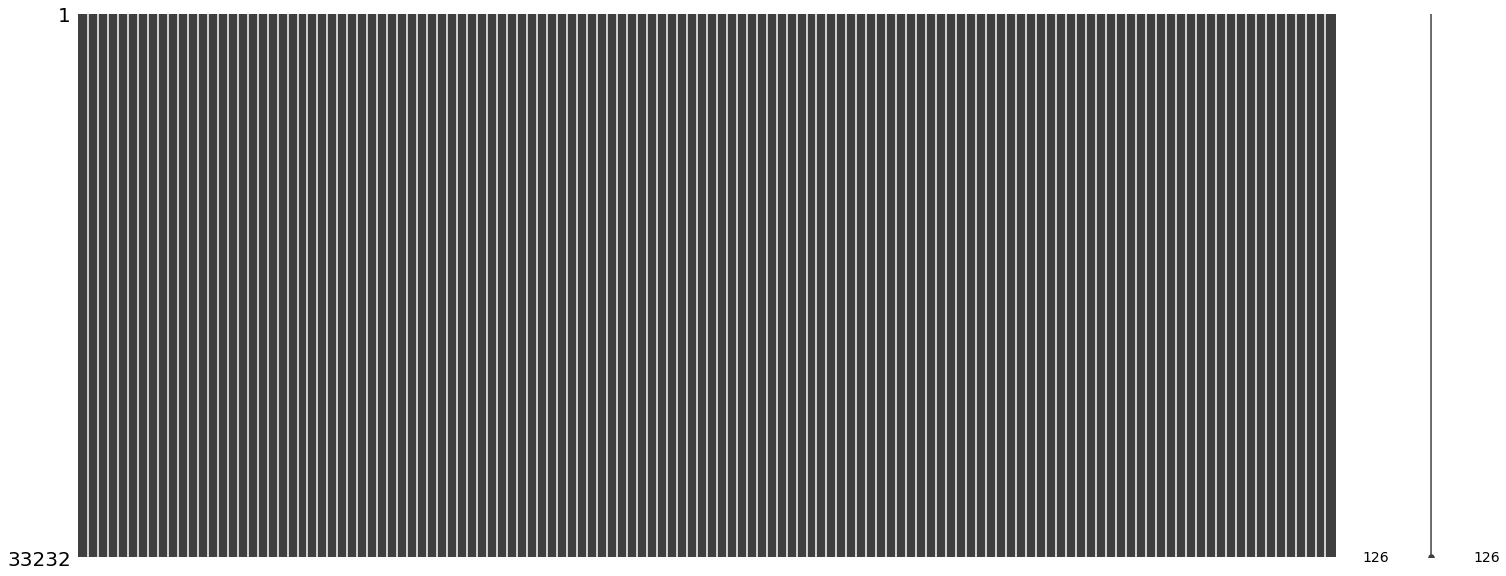

In [71]:
Concat_final.drop(columns=['fillingDate','Date_ID_1'],inplace=True)
                               # 'Classifier 1Y','Classifier 3Y0','Classifier 3Y15'], inplace=True)
# Concat_final=Concat_final.apply (pd.to_numeric, errors='coerce')
# Concat_final.dropna(inplace=True)
Concat_final.to_csv("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\Comparison.csv")
X = Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
                               'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15',\
                               'Ticker','index','True_Return',"neg_class"])
X.to_csv("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\X_compare.csv")

# check if no nan
msno.matrix(X)

In [7]:
# Macroeconomic data can be dropped here. They cause bias.
#X.drop(columns=["CPIAUCSL","UNRATE","INDPRO","GDPC1","AAA","EXUSEU","T5YIFRM"], inplace = True)

In [72]:
# Drop classifiers
# 'Classifier 3Y02' : over 3 years at least 2% annual return
# Ticker: stock ticker (e.g. AAPL for Apple)
# index : year (can cause bias)
# True Return: True Return over 3 years (only needed for later evaluation)
Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
                               'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15',\
                                      'Ticker','index','True_Return'])

,cashAndCashEquivalents,cashAndShortTermInvestments,netReceivables,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwillAndIntangibleAssets,otherNonCurrentAssets,totalNonCurrentAssets,otherAssets,...,enterpriseValue,AAA,CPIAUCSL,EXUSEU,INDPRO,T5YIFRM,UNRATE,GDPC1,adjclose,neg_class
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
3,2.048400e+10,6.715500e+10,2.929900e+10,8.283000e+09,1.070000e+11,2.701000e+10,8.620000e+09,8.757000e+09,2.150000e+11,1.704000e+10,...,7.100000e+11,3.92,243.717,1.0635,103.0366,2.13,4.7,17977.299,27.470144,False
4,2.112000e+10,4.160100e+10,3.034300e+10,1.508500e+10,8.937800e+10,2.247100e+10,9.009000e+09,5.422000e+09,2.010000e+11,2.050700e+10,...,7.090000e+11,4.00,237.827,1.0855,102.9525,1.65,4.9,17613.264,24.422157,False
5,1.384400e+10,2.507700e+10,2.721900e+10,1.412400e+10,6.853100e+10,2.062400e+10,8.758000e+09,3.764000e+09,1.630000e+11,1.788800e+10,...,6.650000e+11,3.46,234.747,1.1615,105.9806,2.02,5.7,17305.752,25.181044,False
6,1.425900e+10,4.054600e+10,2.064100e+10,1.033500e+10,7.328600e+10,1.659700e+10,5.756000e+09,5.146000e+09,1.340000e+11,1.548100e+10,...,4.960000e+11,4.49,235.288,1.3618,102.7216,2.72,6.6,16616.540,17.906834,False
7,1.074600e+10,2.912900e+10,1.869200e+10,9.041000e+09,5.765300e+10,1.545200e+10,5.359000e+09,5.478000e+09,1.180000e+11,1.451900e+10,...,5.600000e+11,3.80,231.679,1.3304,100.8204,2.84,8.0,16382.964,16.569740,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47579,2.262000e+09,2.262000e+09,6.920000e+08,3.770000e+08,3.958000e+09,7.750000e+08,4.680000e+08,2.168000e+09,3.411000e+09,2.545000e+09,...,1.178309e+09,5.30,205.288,1.3246,103.7521,2.32,4.4,15493.328,20.875027,True
47580,2.226000e+09,2.226000e+09,7.530000e+08,7.460000e+08,4.447000e+09,8.730000e+08,3.620000e+08,1.069000e+09,2.304000e+09,1.815000e+09,...,1.178309e+09,5.84,200.700,1.2273,101.6813,2.52,4.7,15302.705,23.261898,True
47581,2.315000e+09,2.315000e+09,1.044000e+09,1.920000e+08,4.577000e+09,1.258000e+09,4.430000e+08,7.780000e+08,2.479000e+09,9.700000e+08,...,1.178309e+09,5.40,193.100,1.3185,99.3061,2.54,5.2,14771.602,14.867786,False


In [73]:
scaler = StandardScaler()

scaler.fit(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
                               'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15',\
                                      'Ticker','index','True_Return'\
                                     ,'AAA','CPIAUCSL','EXUSEU','INDPRO','T5YIFRM','UNRATE','GDPC1',"neg_class"]))
X=scaler.transform(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
                               'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15',\
                                              'Ticker','index','True_Return'\
                                             ,'AAA','CPIAUCSL','EXUSEU','INDPRO','T5YIFRM','UNRATE','GDPC1',"neg_class"])\
                  [Concat_final["index"]<2015])

Y=Concat_final["neg_class"][Concat_final["index"]<2015]


Y_test = Concat_final["neg_class"][Concat_final["index"]>=2015]
X_test = scaler.transform(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
                               'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15',\
                                              'Ticker','index','True_Return'\
                                             ,'AAA','CPIAUCSL','EXUSEU','INDPRO','T5YIFRM','UNRATE','GDPC1',"neg_class"])\
                  [Concat_final["index"]>=2015])


In [10]:
#standard
#scikit classifier
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

## This section is needed for evaluation purposes only, not the actual machine learning
P_Pred =0
TP = 0
FP = []
Pos = []
Pos_Pred = []
TP_75=0
FP_75=0
TP_90=0
FP_90=0
TP_99=0
FP_99=0
Index_List_90 = []
val_precision = []
train_precision = []
TP_this_list =[]
FP_this_list =[]
# dataframe empty
save_year_ticker_return = []
counter =1
##

for train_index, test_index in kfold.split(X, Y):
    
    counter+=1
    clf = RandomForestClassifier(n_estimators=100, bootstrap= False, min_samples_split=2, min_samples_leaf=1,\
                                max_depth=80)
    
    clf.fit(np.array(X)[train_index], np.array(Y)[train_index])
    #Y_Pred=clf.predict(np.array(X)[test_index])
    #Y_Pred_Proba=clf.predict_proba(np.array(X)[test_index])
    Y_Pred=clf.predict(np.array(X_test))
    Y_Pred_Proba=clf.predict_proba(np.array(X_test))
    
    ## This section is needed for evaluation purposes only, not the actual machine learning
    save_year_ticker_return_ = np.array(\
                                       Concat_final[['Ticker','index','True_Return']]\
                                      )[test_index]
    save_year_ticker_return_ = save_year_ticker_return_[Y_Pred_Proba[:,1]>0.8]
    #print("Acc "+str(metrics.accuracy_score(Y[test_index], Y_Pred,normalize=True, sample_weight=None)))
    
    
    TP_This = 0
    FP_This = 0
    Pos_This = 0
    Pos_Pred_This = 0
  
    # Assume we would invest if the predicted probability is higher than 0.75; 0.9; 0.99
    # Therefore evaluate Prescision at these levels
    i=0
    for t in test_index:
        if Y_Pred_Proba[i][1]>0.75:
            if 1==np.array(Y)[t]:
                TP_75+=1
                
            else:
                FP_75+=1
        i+=1
        
        
    i=0
    for t in test_index:
        if Y_Pred_Proba[i][1]>0.9:
            if 1==np.array(Y)[t]:
                TP_90+=1
                TP_This+=1
                Index_List_90.append(t)
            else:
                FP_90+=1
                FP_This+=1
        i+=1
    
    i=0
    for t in test_index:
        if Y_Pred_Proba[i][1]>0.99:
            if 1==np.array(Y)[t]:
                TP_99+=1
            else:
                FP_99+=1
        i+=1




    #TP.append(TP_This)
    FP.append(FP_This)
    #Pos.append(Pos_This)
    #Pos_Pred.append(Pos_Pred_This)
    val_precision.append(TP_This/(TP_This+FP_This))
    TP_this_list.append(TP_This)
    FP_this_list.append(FP_This)
    print("This round: Precision 90: "+str(TP_This/(TP_This+FP_This)))
    
    ##
    
    
#
# try except because often division by 0

try: 
    print("Total Precision high: "+str(TP_99/(TP_99+FP_99))+"\n"+\
      "True Positives:"+ str(TP_99))
except ZeroDivisionError:
    pass


try:
    print("Total Precision mid: "+str(TP_90/(TP_90+FP_90))+"\n"+\
      "True Positives:"+ str(TP_90))
except ZeroDivisionError:
    pass

try:
    print("Total Precision low: "+str(TP_75/(TP_75+FP_75))+"\n"+\
        "True Positives:"+ str(TP_75))
except ZeroDivisionError:
    pass


IndexError: boolean index did not match indexed array along dimension 0; dimension is 5300 but corresponding boolean dimension is 7071

In [74]:
# year split
#scikit classifier
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

## This section is needed for evaluation purposes only, not the actual machine learning
P_Pred =0
TP = 0
FP = []
Pos = []
Pos_Pred = []
TP_75=0
FP_75=0
TP_90=0
FP_90=0
TP_99=0
FP_99=0
Index_List_90 = []
val_precision = []
train_precision = []
TP_this_list =[]
FP_this_list =[]
# dataframe empty
save_year_ticker_return = []
counter =1
##

for train_index, test_index in kfold.split(X, Y):
    
    counter+=1
    clf = RandomForestClassifier(n_estimators=100, bootstrap= False, min_samples_split=2, min_samples_leaf=1,\
                                max_depth=80)
    
    clf.fit(np.array(X)[train_index], np.array(Y)[train_index])
    #Y_Pred=clf.predict(np.array(X)[test_index])
    #Y_Pred_Proba=clf.predict_proba(np.array(X)[test_index])
    Y_Pred=clf.predict(np.array(X_test))
    Y_Pred_Proba=clf.predict_proba(np.array(X_test))
    
    ## This section is needed for evaluation purposes only, not the actual machine learning
    save_year_ticker_return_ = np.array(\
                                       Concat_final[['Ticker','index','True_Return']]\
                                      )[Concat_final["index"]>=2015]
    save_year_ticker_return_1 = save_year_ticker_return_[Y_Pred_Proba[:,1]>0.8]
    save_year_ticker_return_2 = save_year_ticker_return_[Y_Pred_Proba[:,1]>0.65]
    save_year_ticker_return_3 = save_year_ticker_return_[Y_Pred_Proba[:,1]>0.5]
    #print("Acc "+str(metrics.accuracy_score(Y[test_index], Y_Pred,normalize=True, sample_weight=None)))
    
    
    TP_This = 0
    FP_This = 0
    Pos_This = 0
    Pos_Pred_This = 0
  
    # Assume we would invest if the predicted probability is higher than 0.75; 0.9; 0.99
    # Therefore evaluate Prescision at these levels
#     i=0
#     for t in test_index:
#         if Y_Pred_Proba[i][1]>0.75:
#             if 1==np.array(Y)[t]:
#                 TP_75+=1
                
#             else:
#                 FP_75+=1
#         i+=1
        
        
#     i=0
#     for t in test_index:
#         if Y_Pred_Proba[i][1]>0.9:
#             if 1==np.array(Y)[t]:
#                 TP_90+=1
#                 TP_This+=1
#                 Index_List_90.append(t)
#             else:
#                 FP_90+=1
#                 FP_This+=1
#         i+=1
    
#     i=0
#     for t in test_index:
#         if Y_Pred_Proba[i][1]>0.99:
#             if 1==np.array(Y)[t]:
#                 TP_99+=1
#             else:
#                 FP_99+=1
#         i+=1




#     #TP.append(TP_This)
#     FP.append(FP_This)
#     #Pos.append(Pos_This)
#     #Pos_Pred.append(Pos_Pred_This)
#     val_precision.append(TP_This/(TP_This+FP_This))
#     TP_this_list.append(TP_This)
#     FP_this_list.append(FP_This)
#     print("This round: Precision 90: "+str(TP_This/(TP_This+FP_This)))
    
#     ##
    
    
#
# try except because often division by 0

# try: 
#     print("Total Precision high: "+str(TP_99/(TP_99+FP_99))+"\n"+\
#       "True Positives:"+ str(TP_99))
# except ZeroDivisionError:
#     pass


# try:
#     print("Total Precision mid: "+str(TP_90/(TP_90+FP_90))+"\n"+\
#       "True Positives:"+ str(TP_90))
# except ZeroDivisionError:
#     pass

# try:
#     print("Total Precision low: "+str(TP_75/(TP_75+FP_75))+"\n"+\
#         "True Positives:"+ str(TP_75))
# except ZeroDivisionError:
#     pass


In [75]:
Selection = pd.DataFrame(save_year_ticker_return_1, columns = ["Ticker", "year","return"])
Selection2 = pd.DataFrame(save_year_ticker_return_2, columns = ["Ticker", "year","return"])
Selection3 = pd.DataFrame(save_year_ticker_return_3, columns = ["Ticker", "year","return"])

In [98]:
np.mean(Selection2["return"]<0)

0.7518518518518519

In [99]:
Selection2["return"][Selection2["return"]<0].mean()

-0.5804780472807884

In [91]:
Selection2.to_csv("Selection.csv")

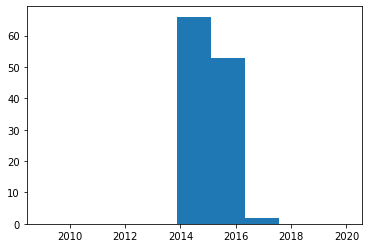

In [43]:
# distribution of selection over years is quite even
# -> the model success is not based on learning: "financial crisis 2008 -> not invest in 2008"
# additionally, we get enough stocks to build a portfolio (way above 50)
figure2 = plt.hist(Selection2["year"], density = False, range = (2009,2020),bins = 9)

In [78]:
# the most frequent element is not too frequent
# the model does not learn "Apple always goes up -> always buy apple"
Selection2["Ticker"].describe()

count      178
unique     129
top       OPTT
freq         3
Name: Ticker, dtype: object

In [44]:
# selection based on full dataset
Concat_final['Ticker'].iloc[Index_List_90].describe()

count       0
unique      0
top       NaN
freq      NaN
Name: Ticker, dtype: object

In [100]:
# The selected Portfolio outperforms... not:
# Selected Portfolio Return
print((np.power(Selection["return"]+1, 1/3)-1).mean())
print((Selection["return"]).mean())
# Benchmark Return: Buy and hold the market
print((np.power(Concat_final["True_Return"]+1, 1/3)-1).mean())
print((Concat_final["True_Return"]).mean())

-0.2936852949329065
-0.37660831215555557
0.05452404500657506
0.33604082454441914


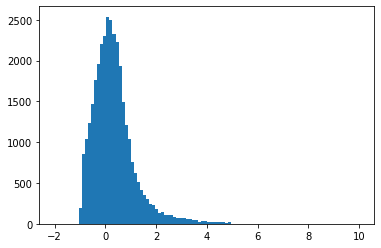

In [51]:
fig = plt.hist(Concat_final["True_Return"],range = (-2,10),bins = 100)

In [64]:
(Selection3["return"]).mean()/Selection3["return"].std()

-0.07024464428865278

In [53]:
Selection["return"].std()

0.5850415317311886

In [26]:
Concat_final["True_Return"][Concat_final["index"]>=2015].std()

0.8141720418835511

In [18]:
Concat_final["True_Return"][Concat_final["index"]>=2015].mean()/Concat_final["True_Return"][Concat_final["index"]>=2015].std()

0.1949654581448407

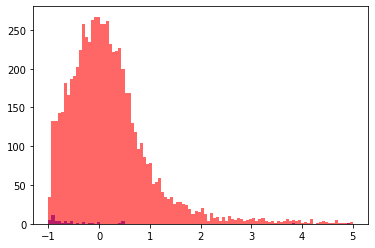

In [96]:
# downside protection is very effective
plt.figure()
figure4 = plt.hist((Selection["return"]),range = (-1,5),bins = 100, density = False, alpha = 0.7, color ="b")
figure3=plt.hist(Concat_final["True_Return"][Concat_final["index"]>=2015]\
                 ,range = (-1,5),bins = 100, density = False, alpha = 0.6, color ="r")

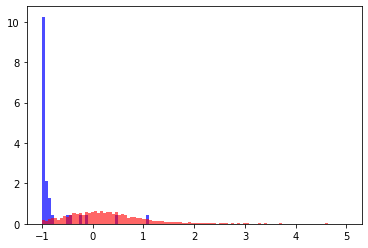

In [51]:
# Outperformance is seen by just eyeballing the return histograms
# blue is the selected portfolio. Density is much lower for returns below 0, which drives outperformance. 
plt.figure()
figure4 = plt.hist((Selection2["return"]),range = (-1,5),bins = 100, density = True, alpha = 0.7, color ="b")
figure3=plt.hist(Concat_final["True_Return"].reindex(index = test_index)\
                 ,range = (-1,5),bins = 100, density = True, alpha = 0.6, color ="r")

C:\Users\Vincent\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


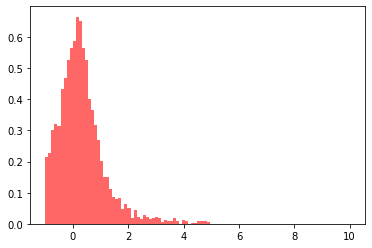

In [104]:
# 

# Outperformance is seen by just eyeballing the return histograms
# blue is the selected portfolio. Density is much lower for returns below 0, which drives outperformance. 
plt.figure()
figure4 = plt.hist((Selection["return"][Selection["year"]<2009]),range = (-1,10),bins = 100, density = True, alpha = 0.7, color ="b")
figure3=plt.hist(Concat_final["True_Return"].reindex(index = test_index)\
                 ,range = (-1,10),bins = 100, density = True, alpha = 0.6, color ="r")

In [70]:
# Outperformance holds even for 2000-2009 period:
# Selected Portfolio Return
print((np.power(Selection["return"][Selection["year"]<2009]+1, 1/3)-1).mean())

# Benchmark Return: Buy and hold the market
print((np.power(Concat_final["True_Return"].reindex(index = test_index)+1, 1/3)-1).mean())

0.17737469838541517
0.057943175851096235


In [21]:
# Importance=pd.DataFrame({'Variable':X.columns,
#               'Importance':clf.feature_importances_}).sort_values('Importance', ascending=False)
# Importance.head(50)

In [68]:
# final fit and pickle clf
clf.fit(np.array(X), np.array(Y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
with open('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_RF.pickle', 'wb') as handle:
    pickle.dump(clf, handle)

# pickle_out = open("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_RF.pickle","rb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()
# pickle scaler

with open('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_Scaler.pickle',"wb") as handle:
    pickle.dump(scaler, handle)

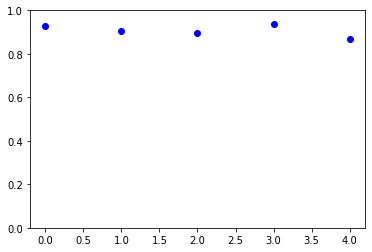

<BarContainer object of 5 artists>

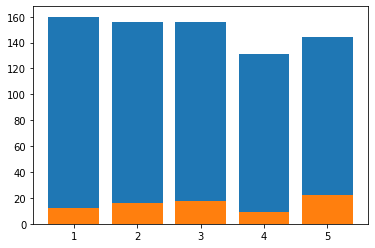

In [32]:
plt.plot(val_precision, "bo")
plt.ylim(ymax = 1, ymin = 0)
plt.show()
plt.bar([1,2,3,4,5],TP_this_list)
plt.bar([1,2,3,4,5],FP_this_list)

## Below follows a Neural Network approach for the same problem

In [36]:
# this has been done for the random forest already

# scaler = StandardScaler()
# scaler.fit(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
#                                'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15','Ticker','index']))
# X=scaler.transform(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
#                                 'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15','Ticker','index']))
# #without scaling
# # X=np.array(Concat_final.drop(columns=['Classifier 3Y02','Classifier 3Y04','Classifier 3Y05',\
# #                                'Classifier 3Y07','Classifier 3Y09','Classifier 3Y15','Ticker','index']))

# Y=Concat_final['Classifier 3Y05']

In [39]:
num_folds = 3
kfold = KFold(n_splits=num_folds, shuffle=True)

# Some containers for storing and plotting:
acc = []
val_acc = []
precision = []
val_precision2 = []
val_precision = []
recall = []
val_recall = []
auc = []
val_auc =[]
Recall_Regime_Weights=[]
TP_Regimes =[]


num_epochs = 10
P_Pred=0
P=Y.sum()
Fold_count=1

#kfold.split(X, Y)
  #https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
for train_index, test_index in kfold.split(X, Y):
    
    P_This_Fold=np.array(Y)[test_index].sum()
    
    Recall_Current_Regime_Weight = P_This_Fold/P    
    Recall_Regime_Weights.append(Recall_Current_Regime_Weight)
    
    print('\n__________________________\n\n Fold Number: '+str(Fold_count)+'\n __________________________\n')
    Fold_count+=1
    
    X_features_set = X[train_index]
    Y_features_set = np.array(Y)[train_index]
    x_features_set = X[test_index]
    y_features_set = np.array(Y)[test_index]
     
    
    input_shape = (119,)
    network=None
    opt=Adam(lr=0.01)
    
    
    Input_object = Input(shape =input_shape, name='Input', dtype='float32')
    
    
    Dense1 = Dense(60, activation='sigmoid', name='Dense1', input_shape=input_shape)(Input_object)
    Dropout1= Dropout(0.08)(Dense1)
    Dense2 = Dense(60, activation='sigmoid', name='Dense2')(Dropout1)
    Dropout2= Dropout(0.08)(Dense2)
    Dense3 = Dense(1, activation='sigmoid', name='Output')(Dropout2)
    
    
    network = Model([Input_object], Dense3)
    
    
  
    network.compile(optimizer=opt,\
                   loss='binary_crossentropy',\
                   metrics=[Precision(thresholds=0.7, name = 'precision'), \
                            Precision(thresholds=0.9, name = 'precision2'),\
                            #Recall(thresholds=0.5, name='recall'), \
                            #AUC(name='auc'), \
                            'accuracy', \
                            TruePositives(name = 'true_positives'), \
                            FalsePositives(name = 'false_positives') \
                           ])
    
    history=network.fit(X_features_set, Y_features_set, epochs=num_epochs, validation_data=(x_features_set, y_features_set))
    
    TP_Regimes.append(history.history['val_true_positives'])
    P_Pred= P_Pred + np.array(history.history['val_true_positives'][-3:]).mean() \
    + np.array(history.history['val_false_positives'][-3:]).mean()
    
    
    acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])
    precision.append(history.history['precision'])
    val_precision.append(history.history['val_precision'])
    val_precision2.append(history.history['val_precision2'])
#     recall.append(history.history['recall'])
#     val_recall.append(history.history['val_recall'])
#     auc.append(history.history['auc'])
#     val_auc.append(history.history['val_auc'])


__________________________

 Fold Number: 1
 __________________________

Train on 13448 samples, validate on 6725 samples
Epoch 1/10
13448/13448 [==============================] - 2s 123us/step - loss: 0.6884 - precision: 0.6122 - precision2: 0.0000e+00 - accuracy: 0.5585 - true_positives: 6612.0000 - false_positives: 4978.0000 - val_loss: 0.6831 - val_precision: 0.0000e+00 - val_precision2: 0.0000e+00 - val_accuracy: 0.5625 - val_true_positives: 3638.0000 - val_false_positives: 2854.0000
Epoch 2/10
13448/13448 [==============================] - 1s 92us/step - loss: 0.6782 - precision: 0.6699 - precision2: 0.0000e+00 - accuracy: 0.5756 - true_positives: 7139.0000 - false_positives: 5276.0000 - val_loss: 0.6823 - val_precision: 0.7246 - val_precision2: 0.0000e+00 - val_accuracy: 0.5639 - val_true_positives: 3634.0000 - val_false_positives: 2841.0000
Epoch 3/10
13448/13448 [==============================] - 1s 91us/step - loss: 0.6746 - precision: 0.6957 - precision2: 0.0000e+00 - accur

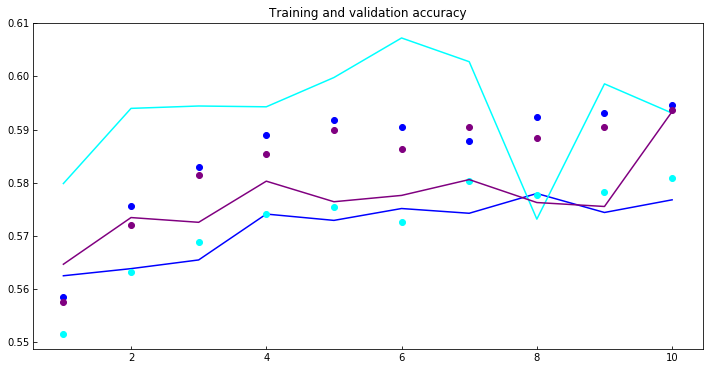

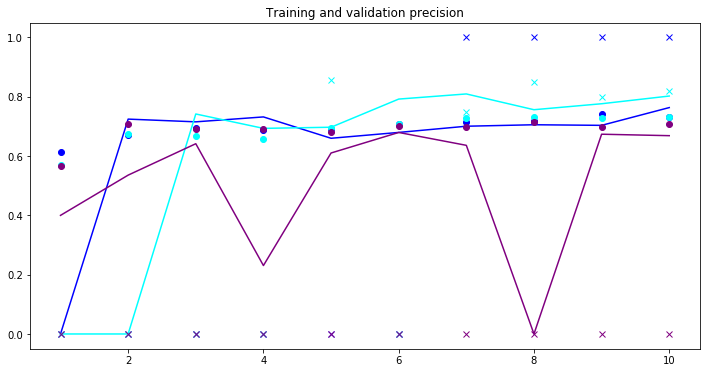

In [41]:
epochs = range(1, len(acc[0]) + 1)


colorlist = ['blue','cyan','purple','pink','orange','red','brown','gray','olive','green']

plt.figure(figsize=(12,6))
i=0
while i <  len(acc):
    plt.plot(epochs, acc[i] , 'bo', label='Training acc', color = colorlist[i])
    plt.plot(epochs, val_acc[i], 'b', label='Validation acc', color=colorlist[i])
    
    ax= plt.gca()
    ax.tick_params(direction='in')
    i+=1
#plt.ylim(ymax = 1, ymin = 0.6)
plt.title('Training and validation accuracy')


plt.figure(figsize=(12,6))
i=0
while i <  len(acc):
    plt.plot(epochs, precision[i] , 'bo', label='Precision', color = colorlist[i])
    
    # precision for different thresholds
    plt.plot(epochs, val_precision[i], 'b', label='val_precision', color=colorlist[i])
    plt.plot(epochs, val_precision2[i], 'x', label='val_precision', color=colorlist[i])
    i+=1
#plt.ylim(ymax = 1, ymin = 0.6)
plt.title('Training and validation precision')

# plt.figure(figsize=(12,6))
# i=0
# while i <  len(acc):
#     plt.plot(epochs, recall[i] , 'bo', label='Recall', color = colorlist[i])
#     plt.plot(epochs, val_recall[i], 'b', label='val_Recall', color=colorlist[i])
#     i+=1

# plt.title('Training and validation recall')

# plt.figure(figsize=(12,6))
# i=0
# while i <  len(acc):
#     plt.plot(epochs, auc[i] , 'bo', label='auc', color = colorlist[i])
#     plt.plot(epochs, val_auc[i], 'b', label='val_auc', color=colorlist[i])
#     i+=1

# plt.title('Training and validation auc')

plt.show()

In [50]:
# train network based on all available data to make final prediction
X_features_set = X[train_index]
Y_features_set = np.array(Y)[train_index]
x_features_set = X[test_index]
y_features_set = np.array(Y)[test_index]
     
    
input_shape = (119,)
network2=None
opt=Adam(lr=0.01)
    
    
Input_object = Input(shape =input_shape, name='Input', dtype='float32')
    
    
Dense1 = Dense(60, activation='sigmoid', name='Dense1', input_shape=input_shape)(Input_object)
Dropout1= Dropout(0.08)(Dense1)
Dense2 = Dense(60, activation='sigmoid', name='Dense2')(Dropout1)
Dropout2= Dropout(0.08)(Dense2)
Dense3 = Dense(1, activation='sigmoid', name='Output')(Dropout2)
    
    
network2 = Model([Input_object], Dense3)
    
network2.compile(optimizer=opt,\
    loss='binary_crossentropy')
    
history2=network2.fit(X_features_set, Y_features_set, epochs=num_epochs, validation_data=(x_features_set, y_features_set))
    

Train on 13449 samples, validate on 6724 samples
Epoch 1/10
13449/13449 [==============================] - 1s 93us/step - loss: 0.6896 - val_loss: 0.6835
Epoch 2/10
13449/13449 [==============================] - 1s 74us/step - loss: 0.6804 - val_loss: 0.6802
Epoch 3/10
13449/13449 [==============================] - 1s 78us/step - loss: 0.6769 - val_loss: 0.6784
Epoch 4/10
13449/13449 [==============================] - 1s 70us/step - loss: 0.6744 - val_loss: 0.6763
Epoch 5/10
13449/13449 [==============================] - 1s 77us/step - loss: 0.6715 - val_loss: 0.6728
Epoch 6/10
13449/13449 [==============================] - 1s 72us/step - loss: 0.6696 - val_loss: 0.6711
Epoch 7/10
13449/13449 [==============================] - 1s 79us/step - loss: 0.6669 - val_loss: 0.6707
Epoch 8/10
13449/13449 [==============================] - 1s 75us/step - loss: 0.6662 - val_loss: 0.6707
Epoch 9/10
13449/13449 [==============================] - 1s 86us/step - loss: 0.6660 - val_loss: 0.6692
Epoch 

In [15]:
with open('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_NN.pickle', 'wb') as handle:
    pickle.dump(history2, handle)
# pickle_out = open("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_RF.pickle","rb")
# pickle.dump(clf, pickle_out)
# pickle_out.close()
# pickle scaler
# scaler = StandardScaler()
# scaler.fit(X)
with open('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_Scaler.pickle',"wb") as handle:
     pickle.dump(scaler, handle)

In [14]:
network.save('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_NN.h5')

In [51]:
network2.save('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_NN_Predict.h5')

## what follows the prediction from November, i.e. "what should I have invested in in November"?

In [58]:
Current =pd.read_csv("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Current\\Current_current.csv")
# Macroeconomic data can be dropped here. They cause bias.
Current.drop(columns=["CPIAUCSL","UNRATE","INDPRO","GDPC1","AAA","EXUSEU","T5YIFRM"], inplace = True)
Current.set_index("Unnamed: 0", inplace = True)
X_current=Current.drop(columns=["Ticker","Probability 1 RF"])
X_current=scaler.transform(X_current)

In [59]:
network2 = load_model('C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Train\\FMP_NN_Predict.h5')
Prediction = network2.predict(X_current)
Current.insert(loc = 1,column = "Probability 1 NN",value =Prediction)

In [69]:
Invest_Suggest =Current[(Current["Probability 1 NN"]>0.9) & (Current["Probability 1 RF"]>0.8)]

In [55]:
Invest_Suggest.to_csv("C:\\Users\\Vincent\\01 Python_Working_Directory\\Z9\\Data\\FMP\\Current\\Invest_SuggestMarch.csv")

In [70]:
Invest_Suggest

,Ticker,Probability 1 NN,Probability 1 RF,cashAndCashEquivalents,cashAndShortTermInvestments,netReceivables,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,goodwillAndIntangibleAssets,...,priceSalesRatio,enterpriseValueMultiple,priceFairValue,stockPrice,numberOfShares,marketCapitalization,minusCashAndCashEquivalents,addTotalDebt,enterpriseValue,adjclose
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
11,ZLAB,0.995027,0.92,2.586040e+08,4.636040e+08,7.024000e+06,7684000,4.848810e+08,3.494600e+07,8.632000e+06,...,0.476646,0.321107,0.011773,82.1300,7.384755e+07,6.065099e+09,2.586040e+08,4.238000e+06,5.810733e+09,83.169998
157,WFC,0.969392,0.84,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,1.357300e+10,8.555000e+09,...,5.868476,-153.870304,0.583491,25.4951,4.105500e+09,1.050000e+11,0.000000e+00,2.310000e+11,3.360000e+11,23.510000
276,V,0.971339,0.91,1.389800e+10,1.663700e+10,3.564000e+09,4810000000,2.501100e+10,2.746000e+09,4.297900e+10,...,88.284635,144.296879,12.020965,192.8784,2.214000e+09,4.270000e+11,1.389800e+10,1.788000e+10,4.310000e+11,199.970001
350,UBFO,0.970981,0.87,3.233320e+08,4.151140e+08,6.517360e+08,0,1.066850e+09,2.914000e+06,4.488000e+03,...,13.162418,-89215.419330,0.000888,6.1100,1.716500e+04,1.048781e+05,3.233320e+08,1.008100e+07,-3.131461e+08,6.002464
447,TOPS,0.943716,0.90,5.611000e+06,5.611000e+06,5.150000e+05,1091000,8.060000e+06,3.632400e+08,0.000000e+00,...,0.031367,-18.280249,0.007292,3.5000,2.921100e+05,1.022385e+06,5.611000e+06,2.618100e+08,2.572214e+08,1.080000
547,TBKCP,0.983422,0.92,2.882780e+08,5.310800e+08,4.761916e+09,0,5.292996e+09,1.054550e+08,1.920410e+08,...,423.990958,25.457337,0.898283,25.6500,2.429890e+07,6.232667e+08,2.882780e+08,6.587130e+08,9.937017e+08,24.653109
1397,OCFCP,0.964287,0.94,7.210490e+08,8.742880e+08,8.335480e+09,0,9.209768e+09,0.000000e+00,5.282040e+08,...,464.365834,41.617995,1.023129,25.2264,5.988100e+07,1.510582e+09,7.210490e+08,3.433920e+08,1.132925e+09,26.471827


In [ ]:
# 6 months returns (from yahoo):
# 40% ZLAB: 91 -> 127
# 0% WFC 40 -> 39.9
# 6% V 206 -> 219
# 21% UBFO 6.5 -> 7.9
# 48% TOPS 1.19 -> 1.77
# 5% TBKCP 26 -> 27.4
# 3% OCFCP 27 -> 27.8

In [71]:
Current["Probability 1 NN"].describe()

count    1777.000000
mean        0.583515
std         0.117257
min         0.144484
25%         0.552127
50%         0.590365
75%         0.659304
max         0.995027
Name: Probability 1 NN, dtype: float64